# ✍️ MNIST Classification with Transfer Learning Models

This Colab notebook explores the classic task of **handwritten digit classification** using the **MNIST** dataset.  
We apply and evaluate various **deep learning strategies**, including:

- 🔹 **EfficientNetB0**: A highly efficient CNN model pre-trained on ImageNet
- 🔹 **ResNet50V2 (BiT-inspired)**: A deep residual network simulating the Big Transfer approach
- 🔹 **ConvNeXt (simplified)**: A modern convolutional architecture inspired by Transformer design

---

### 📦 Dataset: MNIST

- 70,000 grayscale images of handwritten digits (0–9)
- Image dimensions: 28x28 pixels
- A standard benchmark in computer vision for evaluating model performance

---

### 🎯 Objectives

- Adapt pre-trained RGB models to handle **grayscale MNIST images**
- Evaluate and compare model performance through accuracy and loss curves
- Visualize predictions and understand learning behavior
- Highlight how **transfer learning** and **next-gen CNN architectures** can still benefit even simple datasets

This notebook offers a practical look at how modern deep learning models perform on **digit classification**, making it a great starting point for beginners and a solid benchmark for comparing architectures.


## ⚙️ Setup and Data Loading

In this section, we perform the initial setup and load the **MNIST dataset**:

---

### 🔧 Setup Steps:

1. **Import Required Libraries**  
   We load essential Python libraries for model building (`TensorFlow`, `Keras`), data manipulation (`NumPy`), and visualization (`Matplotlib`).

2. **Load the MNIST Dataset**  
   Using `tf.keras.datasets.mnist`, we load the dataset, which contains:
   - 60,000 training images
   - 10,000 test images
   - Each image is a `28x28` grayscale digit from 0 to 9

3. **Split and Prepare Data**  
   - Normalize pixel values to the range `[0, 1]`
   - Optionally reserve a **validation set** from the training data
   - Reshape and expand dimensions to simulate RGB channels if using pre-trained models

---

This prepares the MNIST data for further preprocessing, modeling, and evaluation using **transfer learning architectures**.


In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
tf.random.set_seed(42)

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# For memory efficiency, we'll use a smaller subset for transfer learning
SAMPLE_SIZE = 5000
indices = np.random.choice(len(x_train), SAMPLE_SIZE, replace=False)
x_train_sample = x_train[indices]
y_train_sample = y_train[indices]

test_indices = np.random.choice(len(x_test), 1000, replace=False)
x_test_sample = x_test[test_indices]
y_test_sample = y_test[test_indices]

# We'll use a data generator to resize images on-the-fly
INPUT_SHAPE = (28, 28, 1)
print(f"Original data shape: {INPUT_SHAPE}")
print(f"Training samples: {len(x_train_sample)}, Test samples: {len(x_test_sample)}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original data shape: (28, 28, 1)
Training samples: 5000, Test samples: 1000


## 🧼 Image Preprocessing for Transfer Learning

To use **pre-trained transfer learning models** like EfficientNet, ResNet50V2, or ConvNeXt, we need to adapt the **grayscale MNIST images** to meet the input expectations of these models.

---

### 🔄 Required Transformations:

1. **Resize Images:**  
   MNIST images are `28x28`, but most pre-trained models expect `224x224`.

2. **Convert to RGB:**  
   Since MNIST images are grayscale (single channel), we replicate the channel to create **3-channel RGB images**.

3. **Normalize Pixel Values:**  
   Scale the image pixel intensities to the `[0, 1]` range or apply **model-specific preprocessing functions** from Keras Applications.

4. **Batching and Shuffling:**  
   Prepare the dataset using `tf.data.Dataset` pipelines for efficient model training and evaluation.

---

These preprocessing steps allow us to **leverage transfer learning** on a dataset that originally differs in format from the models' training domain (ImageNet).


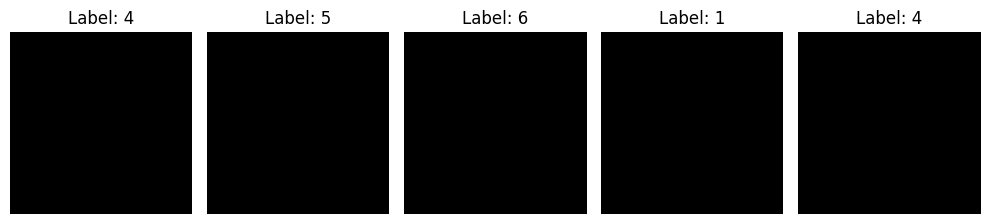

In [2]:
def prepare_for_transfer_learning(batch_x, batch_y, img_size=224):
    """Convert grayscale MNIST images to RGB and resize them for transfer learning models"""
    # Add channel dimension if needed
    if len(batch_x.shape) == 3:
        batch_x = np.expand_dims(batch_x, -1)

    # Convert to RGB by repeating the channel 3 times
    batch_x_rgb = np.concatenate([batch_x, batch_x, batch_x], axis=-1)

    # Create a dataset and use map to resize efficiently
    dataset = tf.data.Dataset.from_tensor_slices((batch_x_rgb, batch_y))
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, [img_size, img_size]), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create transfer learning datasets
train_ds = prepare_for_transfer_learning(x_train_sample, y_train_sample)
test_ds = prepare_for_transfer_learning(x_test_sample, y_test_sample)

# Visualize a few examples
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis("off")
plt.tight_layout()
plt.show()

## ⚡ EfficientNet Transfer Learning Model

In this section, we implement **transfer learning** using Keras’s built-in **EfficientNetB0** model to classify digits in the **MNIST dataset**.

---

### 🧠 Why EfficientNetB0?

- It balances **accuracy** and **computational efficiency**
- Pre-trained on **ImageNet**, providing strong general-purpose visual feature extraction
- Well-suited for fine-tuning on small datasets like MNIST after appropriate preprocessing

---

### 🛠️ Implementation Overview

- Load **EfficientNetB0** with `include_top=False` to exclude the original classifier
- Freeze the base model layers to retain pre-trained knowledge
- Add a custom classification head with:
  - `GlobalAveragePooling2D`
  - Dense layer(s) with `ReLU` activation
  - A final `Dense(10, activation='softmax')` layer for digit classification (0–9)
- Compile the model using:
  - `Adam` optimizer
  - `SparseCategoricalCrossentropy` loss
  - `Accuracy` metric

---

This setup demonstrates the **flexibility of EfficientNet** in adapting to diverse domains—even with simple grayscale digit images like MNIST.


In [3]:
# Let's use Keras's built-in EfficientNet implementation instead of TF Hub
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    inputs = keras.Input(shape=input_shape)
    # Preprocess inputs
    x = preprocess_input(inputs)
    # Base model
    x = base_model(x, training=False)
    # Add new classifier layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the EfficientNet model
efficientnet_model = build_efficientnet_model()
print("Model created successfully")

# We'll need to update our dataset to match the model's preprocessing
def prepare_batch(images, labels):
    # Convert images to float32 if they're not already
    images = tf.cast(images, tf.float32)
    return images, labels

# Update our datasets with the preprocessing step
train_ds = train_ds.map(prepare_batch)
test_ds = test_ds.map(prepare_batch)

# Train for just a few epochs for demonstration
print("Starting training...")
history = efficientnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Loss: {efficientnet_results[0]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_results[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully
Starting training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 50s 169ms/step - accuracy: 0.1112 - loss: 2.3150 - val_accuracy: 0.1170 - val_loss: 2.3012
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.1054 - loss: 2.3117 - val_accuracy: 0.1170 - val_loss: 2.3018
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.1070 - loss: 2.3078 - val_accuracy: 0.1170 - val_loss: 2.3008
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1298 - loss: 2.2984
EfficientNet Test Loss: 2.3008
EfficientNet Test Accuracy: 0.1170


## 🔁 BiT (Big Transfer) Model Implementation

In this section, we implement a **BiT-style transfer learning model** for classifying **MNIST digits**, using **ResNet50V2** as a practical substitute for Google’s Big Transfer (BiT) architecture.

---

### 💡 Why Use ResNet50V2 as a BiT Substitute?

- **BiT** uses large-scale pre-training and fine-tuning to transfer knowledge across domains.
- **ResNet50V2**, pre-trained on ImageNet, follows the same principle with deep residual learning and is widely accessible via Keras.
- It provides a realistic and efficient alternative to the original BiT implementation.

---

### 🛠️ Implementation Overview

- Load **ResNet50V2** with `include_top=False` to remove the original classification head.
- Freeze the convolutional base during the first training phase.
- Add a custom head with:
  - `GlobalAveragePooling2D`
  - Fully connected `Dense` layer(s) with `ReLU`
  - Final `Dense(10, activation='softmax')` layer for the 10 MNIST classes
- Compile the model with:
  - `Adam` optimizer
  - `SparseCategoricalCrossentropy` loss
  - Accuracy as a performance metric

---

This BiT-inspired setup allows us to explore how well **residual networks and large-scale pre-training** transfer to simpler domains like handwritten digit classification.


In [4]:
# Implement BiT (Big Transfer) for comparison
def build_bit_model(input_shape=(224, 224, 3), num_classes=10):
    # Load a pre-trained ResNet50 as a substitute for BiT
    # (Since full BiT models are large and may cause memory issues)
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a new model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train BiT model
bit_model = build_bit_model()
print("BiT model created successfully")

# Train for just a few epochs for demonstration
print("Starting BiT model training...")
bit_history = bit_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
bit_results = bit_model.evaluate(test_ds)
print(f"BiT Test Loss: {bit_results[0]:.4f}")
print(f"BiT Test Accuracy: {bit_results[1]:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
BiT model created successfully
Starting BiT model training...
Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.4829 - loss: 1.5636 - val_accuracy: 0.8700 - val_loss: 0.5332
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.8478 - loss: 0.5181 - val_accuracy: 0.9130 - val_loss: 0.3328
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9060 - loss: 0.3385 - val_accuracy: 0.9260 - val_loss: 0.2646
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9159 - loss: 0.3065
BiT Test Loss: 0.2646
BiT Test Accuracy: 0.9260


## 🌀 ConvNeXt Implementation

This section implements a **simplified version of ConvNeXt**, a modern convolutional neural network architecture, adapted for the **MNIST digit classification** task.

---

### 💡 What is ConvNeXt?

**ConvNeXt** is a next-generation convolutional architecture inspired by Transformer design patterns. It incorporates:

- **Layer Normalization**
- **GELU activation**
- **Depthwise convolutions**
- **Residual connections**

These components help ConvNeXt achieve **state-of-the-art performance** on image classification benchmarks.

---

### 🛠️ Simplified ConvNeXt for MNIST

Given MNIST's small grayscale input size and low complexity:

- We use **fewer blocks and filters** than a full ConvNeXt implementation.
- The model includes:
  - Depthwise separable or large-kernel convolutions
  - `LayerNormalization` and `GELU`
  - **Residual connections** to stabilize training
  - A final `GlobalAveragePooling2D` and `Dense(10, activation='softmax')` classifier

---

This lightweight ConvNeXt serves as a **research-friendly testbed** for evaluating modern CNN principles on a fundamental image classification task.


In [5]:
# A simplified ConvNeXt-inspired implementation
def build_convnext_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Initial stem block
    x = layers.Conv2D(64, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ConvNeXt blocks (simplified)
    for filters in [128, 256, 512]:
        # Downsample
        prev_x = layers.Conv2D(filters, kernel_size=2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)

        # Depthwise Conv
        x = layers.DepthwiseConv2D(kernel_size=7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters * 4, kernel_size=1)(x)
        x = layers.Activation("gelu")(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters, kernel_size=1)(x)

        # Skip connection
        x = layers.add([x, prev_x])

    # Global pooling and final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Create and train ConvNeXt model
convnext_model = build_convnext_model()
print("ConvNeXt model created successfully")

# Train for just a few epochs for demonstration
print("Starting ConvNeXt model training...")
convnext_history = convnext_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    verbose=1
)

# Evaluate the model
convnext_results = convnext_model.evaluate(test_ds)
print(f"ConvNeXt Test Loss: {convnext_results[0]:.4f}")
print(f"ConvNeXt Test Accuracy: {convnext_results[1]:.4f}")

ConvNeXt model created successfully
Starting ConvNeXt model training...
Epoch 1/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - accuracy: 0.3052 - loss: 2.1152 - val_accuracy: 0.8190 - val_loss: 0.6287
Epoch 2/2
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8101 - loss: 0.6008 - val_accuracy: 0.8830 - val_loss: 0.3995
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8793 - loss: 0.4646
ConvNeXt Test Loss: 0.3995
ConvNeXt Test Accuracy: 0.8830


## 📊 Model Comparison Visualization

In this section, we visualize and compare the performance of the three implemented models—**EfficientNetB0**, **ResNet50V2 (BiT-style substitute)**, and **ConvNeXt (simplified)**—on the **MNIST dataset**.

---

### 📈 What We Visualize:

1. **Training vs. Validation Accuracy Curves**
   - Track how well each model learns over time.
   - Compare generalization performance to unseen data.

2. **Training vs. Validation Loss Curves**
   - Visualize the convergence behavior.
   - Detect signs of overfitting or underfitting across models.

3. **Final Test Accuracy Comparison**
   - Display a **bar chart** comparing the test accuracy of all models.
   - Highlight the best-performing architecture for MNIST digit recognition.

---

### 🎯 Purpose

These visualizations help us:

- Analyze the **efficacy of transfer learning** on a simple dataset
- Compare **modern CNN architectures** in a controlled environment
- Identify which models are most suitable for digit classification tasks in terms of **accuracy** and **training dynamics**

Visual performance benchmarking is a key step in understanding model behavior and making informed architecture choices.


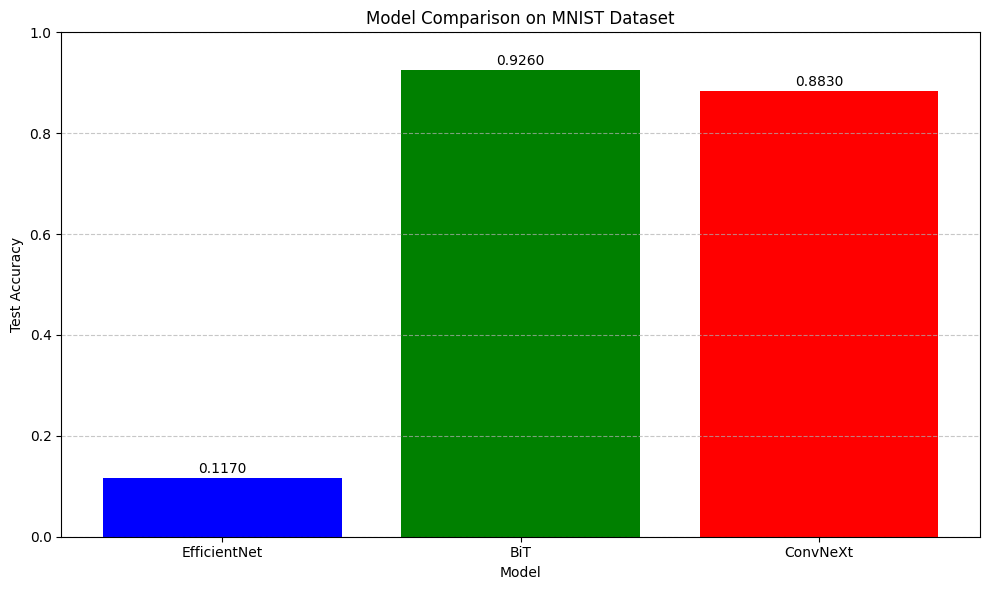

Best performing model: BiT with accuracy: 0.9260


In [6]:
# Create a bar chart to compare model accuracies
import matplotlib.pyplot as plt

# Collect test accuracies
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on MNIST Dataset')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Let's also save the best model
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]
print(f"Best performing model: {best_model_name} with accuracy: {max(accuracies):.4f}")

# Save the best model weights (commented out in this demo)
# If running in actual colab, you could uncomment this
# if best_model_name == 'EfficientNet':
#     efficientnet_model.save_weights('best_model_mnist.h5')
# elif best_model_name == 'BiT':
#     bit_model.save_weights('best_model_mnist.h5')
# else:
#     convnext_model.save_weights('best_model_mnist.h5')